<H2 style="color:blue;font-size:20px;"align="right">فاطمه شاه حسینی</H2>
<H2 style="color:blue;font-size:20px;"align="right">شماره دانشجویی:  810199440 </H2>
<H2 style="color:blue;font-size:20px;"align="right"> (شبکه عصبی)   تمرین کامپیوتری شماره پنج </H2>
<H2 style="color:green;font-size:20px;"align="right"> هدف </H2>
<H2 style="color:black;font-size:15px;"align="right"> آموزش شبکه عصبی به صورت دستی و با استفاده از پکیج ها و بررسی اثر پارامتر های سایز بسته، ضریب نرخ آموزش، اکتیویشن فانکشن ها و وزن اولیه بر دقت شبکه   </H2>
<H2 style="color:green;font-size:20px;"align="right"> توضیح کلی پروژه </H2>
<H2 style="color:black;font-size:15px;"align="right"> ابتدا با کامل کردن بخش های ناقص تابع شبکه عصبی به طور دستی پس های فوروارد و بکوارد و اپدیت شدن وزن ها را انجام می دهیم. در بخش بعدی بعد از انجام پیش پردازش دیتای داده شده و استخراج ویژگی ها از متن نظر، با کمک کتابخانه پای تورچ شبکه عصبی را ترین می کنیم و درنهایت تاثیر پارامتر های مختلف روی دقت شبکه را بررسی می کنیم  </H2>

# MLP from scratch
In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

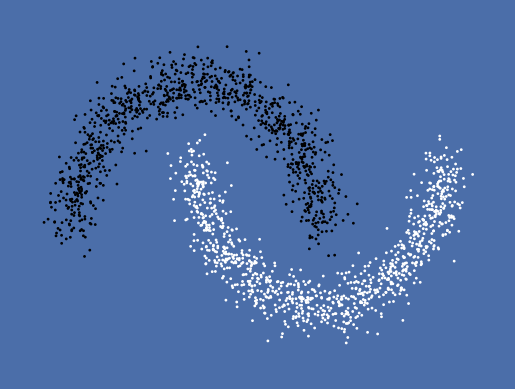

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()


In [2]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.forward(to_forward.T)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [3]:
class MyReLU(object):
    def forward(self, x):
        # # the relu is y_i = max(0, x_i)
        self.x = (np.asarray(x) > 0).astype('float')
        return self.x * x
        
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        return self.x * grad_output
    
    def step(self, learning_rate):
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.x = np.exp(-np.asarray(x))
        return 1 / (1 + self.x)
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        return (grad_output*self.x)/np.power(self.x+1,2)
    def step(self, learning_rate):
        pass

In [4]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([ 0. , -0. ,  0.5, -0. ,  0.8,  1. ])

In [5]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [6]:
test_sig = MySigmoid()
test_sig.forward(np.ones(1))

array([0.73105858])

In [7]:
test_sig.backward(np.ones(1))

array([0.19661193])

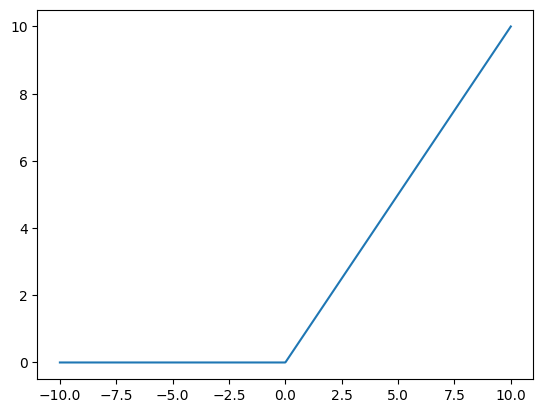

In [8]:
x = (np.linspace(-10, 10, num=1000))
s = MyReLU()
a = s.forward(x)
plt.plot(x, a)

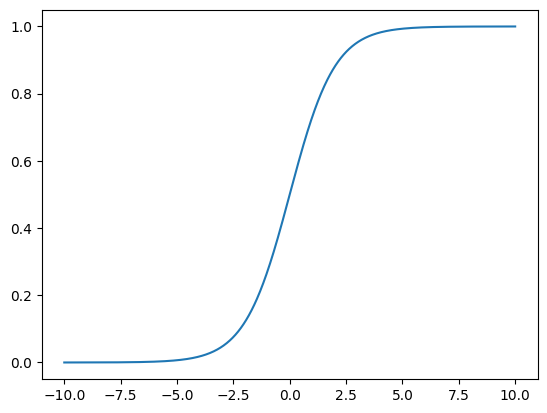

In [9]:
x = (np.linspace(-10, 10, num=1000))
s = MySigmoid()
a = s.forward(x)

plt.plot(x, a)

A bit more complcated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [10]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.W = np.random.randn(n_output,n_input)
        self.b = np.random.randn(n_output,1)
        self.x = None
        self.gradW = None
        self.gradB = None
        
    def forward(self, x):
        self.x = x.copy()
        return np.matmul(self.W ,np.asarray(x)) + self.b

    def backward(self, grad_output):
        self.gradW = np.transpose(self.x @ np.transpose(grad_output))
        self.gradB = grad_output.copy()
        return np.matmul(self.W.T, grad_output)
    
    def step(self, learning_rate):
        self.W -= learning_rate * self.gradW
        self.b -= learning_rate * self.gradB

In [11]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.layers = [MyLinear(2,50),MyReLU(),MyLinear(50,1),MySigmoid()]
        self.gradiant = None
        self.loss = None
        
    def forward(self, x):
        xOut = x.copy()
        for layer in self.layers:
            xOut = layer.forward(xOut)
        return xOut
    
    def compute_loss(self, out, label):
        if label==1 :
          self.gradiant = - label / (out + 1e-10)
        else : 
          self.gradiant = (1-label) / (1-out + 1e-10)
        loss =  - (label * np.log(out) + (1-label) * np.log(1-out))
        return loss

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        grad = self.gradiant
        for l in reversed(self.layers):
            grad = l.backward(grad)
            
    def step(self, learning_rate):
        # take a gradient step for each layers
        for l in self.layers:
            l.step(learning_rate)

In [12]:
# define your network with your Sequential Class
neural_network = Sequential()
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        idx = np.random.randint(len(X))
        # select the corresponding example and label
        label = Y[idx]
        example = X[idx:idx+1]
        # do a forward pass on the example
        forwardRes = neural_network.forward(np.transpose(example))
        # compute the loss according to your output and the label
        lossRes = neural_network.compute_loss(forwardRes,label)
        losses.append(lossRes.squeeze())
        # backward pass
        neural_network.backward()
        # gradient step
        neural_network.step(learning_rate)

As we expected The more epochs we pass, the less the error rate becomes. Which means that our neural network is training, and weights were changed in order to minimize the error rate.

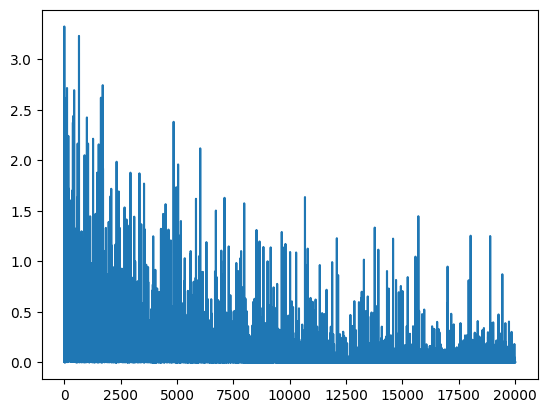

In [13]:
%matplotlib inline
plt.plot(losses)
plt.show()

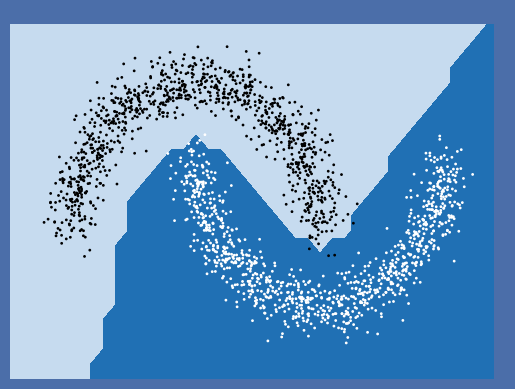

In [14]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, neural_network)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [15]:
# Load 5000 data from .csv file to dataframe

ds = pd.read_csv('./imdb_dataset.csv')
ds.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [16]:
# Label encode the categorical column  "sentiment"

ds['sentiment'] = ds['sentiment'].astype('category')
ds['sentiment'] = ds['sentiment'].cat.codes

ds.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


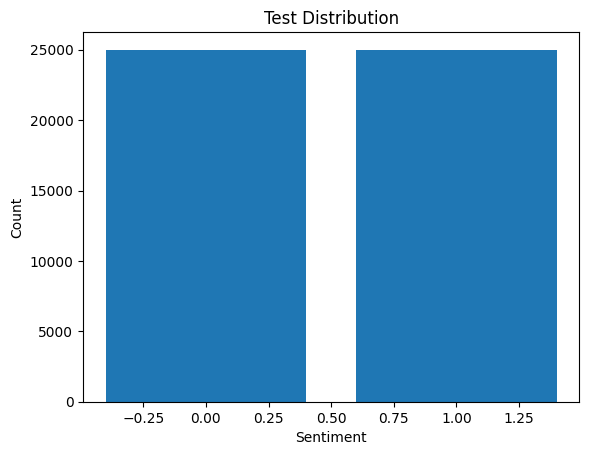

In [17]:
# Plot the data class distribution
test_counts = ds['sentiment'].value_counts()
test_labels = test_counts.index
test_values = test_counts.values

plt.bar(test_labels, test_values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Test Distribution')
plt.show()

In [18]:
#Remove StopWords and Punctuations

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

tokenized_sents = [tokenizer.tokenize(w.replace('<br />', '').strip()) for w in ds['review']]

stop_words = set(stopwords.words('english'))

filtered_sentence = []
for tok_sent in tokenized_sents:
    filtered_sentence.append(" ".join([w for w in tok_sent if not w.lower() in stop_words]))

In [19]:
# A review after removeing StopWords and Punctuations
filtered_sentence[:1]

['One reviewers mentioned watching 1 Oz episode hooked right exactly happened first thing struck Oz brutality unflinching scenes violence set right word GO Trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called OZ nickname given Oswald Maximum Security State Penitentary focuses mainly Emerald City experimental section prison cells glass fronts face inwards privacy high agenda Em City home many Aryans Muslims gangstas Latinos Christians Italians Irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare Forget pretty pictures painted mainstream audiences forget charm forget romance OZ mess around first episode ever saw struck nasty surreal say ready watched developed taste Oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street sk

<H2 style="color:blue;font-size:20px;"align="right"> TF-IDF </H2>
<H2 style="color:black;font-size:15px;"align="right">    
   به معنای نرخ دیده شدن یک واژه در یک متن است و نشان می دهد یک کلمه چقدر با محتوای متن در ارتباط است (TF)</H2>
<H2 style="color:black;font-size:15px;"align="right">    
   نشان می دهد در بین تمام متن هایی داریم، این واژه در چند متن دیده شده است که هر چقدر کلمه در متون بیشتری دیده شده باشد   (IDF)</H2>
<H2 style="color:black;font-size:15px;"align="right">    
 یعنی کلمه رایج تری است و اطلاعات کمتری درباره یک متن خاص به ما می دهد </H2>     
<H2 style="color:black;font-size:15px;"align="right">
ترکیب حاصل از ضرب ایندو معیاری می دهد که  هر چه قدر بالاتر باشد، یعنی با آن واژه بهتر می توان یک متن را از بقیه متون تشخیص داد و آن واژه حاوی اطلاعات زیادی درباره 
متن است
</H2>
<img src="tf-idf.png" width="500" height="600">

<H2 style="color:green;font-size:15px;">   Stemming </H2>
Stemming is a technique used to reduce an inflected word down to its word stem. Not only does it help with reducing redundancy, as most of the time the word stem and their inflected words have the same meaning, it also allows NLP models to learn links between inflected words and their word stem, which helps the model understand their usage in similar contexts. 
<H2 style="color:green;font-size:15px;">   Lemmatization </H2>
Lemmatization is another technique used to reduce inflected words to their root word.As opposed to stemming, lemmatization relies on accurately determining the intended part-of-speech and the meaning of a word based on its context.For example, you can expect a lemmatization algorithm to map “runs,” “running,” and “ran” to the lemma, “run.”

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer     
from nltk.stem import WordNetLemmatizer 

y = ds['sentiment']

X_train, X_test, Y_train, Y_test = train_test_split(filtered_sentence, y, test_size=0.2, random_state=0)

In [21]:
# Find features in review texts using TF_IDF
import nltk
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer     
from nltk.stem import WordNetLemmatizer 

def LemmaTokenizer(text):
    tok = WordNetLemmatizer()
    return [tok.lemmatize(word,pos='v') for word in text.split() ]

vectorizer = TfidfVectorizer(max_features = 6000,tokenizer =LemmaTokenizer )
# Fit and transform the reviews into TF-IDF vectors
tfidfTrain = vectorizer.fit_transform(X_train).toarray()
tfidfTest = vectorizer.transform(X_test).toarray()

# def countVectorize(n, arr, ngf):
#     vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(ngf, 2),
#                                  stop_words='english', min_df = n, max_features=3000, tokenizer=LemmaTokenizer)  
#     vectorized = vectorizer.fit_transform(arr)
#     a = pd.DataFrame(vectorized.toarray(), index=['sentence '+str(i) for i in range(1, 1+len(arr))],columns=vectorizer.get_feature_names_out())
#     return a.reset_index().drop(columns = 'index', axis = 1)

# # ds_vc = pd.concat([ds, countVectorize(223, filtered_sentence , 1)], axis = 1)
# # ds_vc = ds_vc.drop(columns = ['review'], axis = 1)

# # ds_vc.head()
# train_vc = countVectorize(223, X_train , 1)
# train_vc.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fateme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Fateme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


We have to check that all of the trained data are between 0 and 1.Otherwise the TF or IDF have not been normalized properly.

In [22]:
tfidfTrain.all() < 0 or tfidfTrain.all() > 1

False

In [23]:
# Print a positive and a negetive review
import random

pos_reviews = ds.loc[ds['sentiment'] == 1]
neg_reviews = ds.loc[ds['sentiment'] == 0]

pos = pos_reviews.sample(1)
neg = neg_reviews.sample(1)

print("positive: ", pos['review'])
print("negative: ", neg['review'])

positive:  48535    it's a great movie for the whole family. i don...
Name: review, dtype: object
negative:  8661    ZERO stars out of ****<br /><br />Endless Desc...
Name: review, dtype: object


## 3.2. MLP in torch

In [24]:
dTrain = torch.tensor(tfidfTrain, dtype=torch.float32)
lTrain = torch.tensor(Y_train, dtype=torch.float32)
dTest = torch.tensor(tfidfTest, dtype=torch.float32)
lTest = torch.tensor(Y_test.values, dtype=torch.float32)

# create DataLoader, then take one batch
loaderTrain64 = DataLoader(list(zip(dTrain, lTrain)), shuffle=True, batch_size=64)
loaderTest64 = DataLoader(list(zip(dTest, lTest)), shuffle=True, batch_size=64)

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [25]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.A = nn.Parameter(torch.randn(n_output, n_input))
        self.b = nn.Parameter(torch.randn(n_output))
        # self.A = torch.randn(n_output, n_input)
        # self.B = torch.randn(n_output)

    def forward(self, x):
        # YOUR CODE HERE
        return torch.matmul(x,self.A.t()) + self.b
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        x = torch.tensor(x)
        relu = nn.ReLU()
        return relu(x)

In [26]:
from torch import optim
from tqdm import tqdm

TNetWork = nn.Sequential(
        MyLinear_mod(6000, 64),
        MyReLU_mod(),
        MyLinear_mod(64,64 ),
        MyReLU_mod(),
        MyLinear_mod(64, 1),
        nn.Sigmoid()
    )

def find_loss(epochs, learning_rate, loaderTrain):
    
    optimizer = optim.SGD(TNetWork.parameters(), lr=learning_rate)
    losses = []
    criterion = nn.BCELoss()
    for epoch in tqdm(range(epochs)):
        lossval =[]
        for batch,(X, y) in enumerate(loaderTrain):
            # do a forward pass on the batch
            forwardOut = TNetWork(X)
            
            # compute the loss according to your output and the label
            loss = criterion(forwardOut.squeeze(), y)
            lossval.append(loss.item())
            
            # zero the gradients
            optimizer.zero_grad()

            # backward pass
            loss.backward()

            # gradient step
            optimizer.step()
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(loaderTrain.dataset):>5d}]")
        losses.append(sum(lossval)/len(lossval))
    return losses

In [28]:
losses = find_loss(epochs = 100, learning_rate = 1e-2, loaderTrain = loaderTrain64)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fateme\AppData\Local\Temp\ipykernel_8768\445800402.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


loss: 27.187193  [    0/40000]
loss: 30.043642  [ 6400/40000]
loss: 11.044622  [12800/40000]
loss: 3.396976  [19200/40000]
loss: 2.915616  [25600/40000]
loss: 1.920771  [32000/40000]


  1%|▊                                                                                 | 1/100 [00:02<04:26,  2.69s/it]

loss: 1.436442  [38400/40000]
loss: 1.108636  [    0/40000]
loss: 1.228121  [ 6400/40000]
loss: 1.196513  [12800/40000]
loss: 1.075608  [19200/40000]
loss: 0.933234  [25600/40000]
loss: 1.089466  [32000/40000]


  2%|█▋                                                                                | 2/100 [00:05<04:21,  2.67s/it]

loss: 0.985703  [38400/40000]
loss: 0.821054  [    0/40000]
loss: 0.944063  [ 6400/40000]
loss: 0.859120  [12800/40000]
loss: 0.638335  [19200/40000]
loss: 0.921925  [25600/40000]
loss: 0.809935  [32000/40000]


  3%|██▍                                                                               | 3/100 [00:08<04:21,  2.70s/it]

loss: 1.051943  [38400/40000]
loss: 0.784945  [    0/40000]
loss: 0.860059  [ 6400/40000]
loss: 0.750213  [12800/40000]
loss: 1.008896  [19200/40000]
loss: 0.768202  [25600/40000]
loss: 0.898854  [32000/40000]


  4%|███▎                                                                              | 4/100 [00:10<04:19,  2.70s/it]

loss: 0.746237  [38400/40000]
loss: 0.789007  [    0/40000]
loss: 0.849441  [ 6400/40000]
loss: 0.820869  [12800/40000]
loss: 0.791458  [19200/40000]
loss: 0.781152  [25600/40000]
loss: 1.055188  [32000/40000]


  5%|████                                                                              | 5/100 [00:13<04:15,  2.69s/it]

loss: 0.768303  [38400/40000]
loss: 0.781093  [    0/40000]
loss: 1.733058  [ 6400/40000]
loss: 0.868089  [12800/40000]
loss: 0.790729  [19200/40000]
loss: 0.695331  [25600/40000]
loss: 0.694844  [32000/40000]


  6%|████▉                                                                             | 6/100 [00:16<04:13,  2.70s/it]

loss: 0.747630  [38400/40000]
loss: 1.067721  [    0/40000]
loss: 0.738654  [ 6400/40000]
loss: 0.748887  [12800/40000]
loss: 0.977216  [19200/40000]
loss: 1.126700  [25600/40000]
loss: 0.780342  [32000/40000]


  7%|█████▋                                                                            | 7/100 [00:18<04:09,  2.68s/it]

loss: 0.702981  [38400/40000]
loss: 1.031810  [    0/40000]
loss: 0.746782  [ 6400/40000]
loss: 0.807476  [12800/40000]
loss: 1.092122  [19200/40000]
loss: 1.152261  [25600/40000]
loss: 1.095702  [32000/40000]


  8%|██████▌                                                                           | 8/100 [00:21<04:11,  2.74s/it]

loss: 0.750119  [38400/40000]
loss: 0.645524  [    0/40000]
loss: 0.769786  [ 6400/40000]
loss: 1.171003  [12800/40000]
loss: 0.824563  [19200/40000]
loss: 0.743942  [25600/40000]
loss: 0.964534  [32000/40000]


  9%|███████▍                                                                          | 9/100 [00:24<04:05,  2.70s/it]

loss: 0.666578  [38400/40000]
loss: 0.959060  [    0/40000]
loss: 0.673135  [ 6400/40000]
loss: 0.779405  [12800/40000]
loss: 0.765900  [19200/40000]
loss: 0.704923  [25600/40000]
loss: 1.262518  [32000/40000]


 10%|████████                                                                         | 10/100 [00:27<04:03,  2.71s/it]

loss: 0.935767  [38400/40000]
loss: 1.445681  [    0/40000]
loss: 0.720763  [ 6400/40000]
loss: 0.697911  [12800/40000]
loss: 0.774429  [19200/40000]
loss: 0.999987  [25600/40000]
loss: 0.882731  [32000/40000]


 11%|████████▉                                                                        | 11/100 [00:29<04:07,  2.78s/it]

loss: 0.683688  [38400/40000]
loss: 0.696343  [    0/40000]
loss: 0.745321  [ 6400/40000]
loss: 0.713193  [12800/40000]
loss: 0.595667  [19200/40000]
loss: 0.936879  [25600/40000]
loss: 0.777975  [32000/40000]


 12%|█████████▋                                                                       | 12/100 [00:33<04:17,  2.92s/it]

loss: 0.872047  [38400/40000]
loss: 0.787591  [    0/40000]
loss: 0.684546  [ 6400/40000]
loss: 0.859375  [12800/40000]
loss: 0.698122  [19200/40000]
loss: 1.416767  [25600/40000]
loss: 0.905624  [32000/40000]


 13%|██████████▌                                                                      | 13/100 [00:35<04:04,  2.81s/it]

loss: 1.161987  [38400/40000]
loss: 1.033624  [    0/40000]
loss: 0.741601  [ 6400/40000]
loss: 0.733979  [12800/40000]
loss: 0.706378  [19200/40000]
loss: 0.765352  [25600/40000]
loss: 0.931123  [32000/40000]


 14%|███████████▎                                                                     | 14/100 [00:38<03:57,  2.77s/it]

loss: 0.625600  [38400/40000]
loss: 0.819001  [    0/40000]
loss: 0.652508  [ 6400/40000]
loss: 0.937885  [12800/40000]
loss: 0.784043  [19200/40000]
loss: 0.724162  [25600/40000]
loss: 0.731087  [32000/40000]


 15%|████████████▏                                                                    | 15/100 [00:41<03:55,  2.77s/it]

loss: 0.766232  [38400/40000]
loss: 0.668777  [    0/40000]
loss: 0.730643  [ 6400/40000]
loss: 0.957122  [12800/40000]
loss: 0.950664  [19200/40000]
loss: 0.791741  [25600/40000]
loss: 0.733547  [32000/40000]


 16%|████████████▉                                                                    | 16/100 [00:44<03:55,  2.80s/it]

loss: 0.644583  [38400/40000]
loss: 0.672846  [    0/40000]
loss: 0.752147  [ 6400/40000]
loss: 1.052693  [12800/40000]
loss: 0.690473  [19200/40000]
loss: 1.077850  [25600/40000]
loss: 0.695017  [32000/40000]


 17%|█████████████▊                                                                   | 17/100 [00:47<04:14,  3.07s/it]

loss: 0.959915  [38400/40000]
loss: 0.702899  [    0/40000]
loss: 1.135949  [ 6400/40000]
loss: 1.276276  [12800/40000]
loss: 1.108147  [19200/40000]
loss: 0.569131  [25600/40000]
loss: 0.727116  [32000/40000]


 18%|██████████████▌                                                                  | 18/100 [00:50<04:14,  3.10s/it]

loss: 0.807235  [38400/40000]
loss: 0.681284  [    0/40000]
loss: 0.700858  [ 6400/40000]
loss: 0.935186  [12800/40000]
loss: 0.872895  [19200/40000]
loss: 0.703867  [25600/40000]
loss: 1.405543  [32000/40000]


 19%|███████████████▍                                                                 | 19/100 [00:53<04:03,  3.01s/it]

loss: 0.892877  [38400/40000]
loss: 0.944855  [    0/40000]
loss: 0.832462  [ 6400/40000]
loss: 0.989425  [12800/40000]
loss: 0.829568  [19200/40000]
loss: 1.298470  [25600/40000]
loss: 0.892515  [32000/40000]


 20%|████████████████▏                                                                | 20/100 [00:57<04:12,  3.16s/it]

loss: 0.689457  [38400/40000]
loss: 1.122449  [    0/40000]
loss: 0.680695  [ 6400/40000]
loss: 0.823481  [12800/40000]
loss: 0.775144  [19200/40000]
loss: 1.099565  [25600/40000]
loss: 1.109279  [32000/40000]


 21%|█████████████████                                                                | 21/100 [00:59<03:59,  3.03s/it]

loss: 0.971016  [38400/40000]
loss: 0.648944  [    0/40000]
loss: 0.619569  [ 6400/40000]
loss: 0.728298  [12800/40000]
loss: 0.612242  [19200/40000]
loss: 0.796144  [25600/40000]
loss: 1.001522  [32000/40000]


 22%|█████████████████▊                                                               | 22/100 [01:02<03:51,  2.97s/it]

loss: 0.711215  [38400/40000]
loss: 0.781337  [    0/40000]
loss: 0.886185  [ 6400/40000]
loss: 0.678330  [12800/40000]
loss: 0.666919  [19200/40000]
loss: 1.305941  [25600/40000]
loss: 0.913691  [32000/40000]


 23%|██████████████████▋                                                              | 23/100 [01:05<03:42,  2.89s/it]

loss: 0.728829  [38400/40000]
loss: 0.719058  [    0/40000]
loss: 1.076043  [ 6400/40000]
loss: 0.723174  [12800/40000]
loss: 1.201513  [19200/40000]
loss: 0.724267  [25600/40000]
loss: 0.744543  [32000/40000]


 24%|███████████████████▍                                                             | 24/100 [01:08<03:42,  2.93s/it]

loss: 0.814823  [38400/40000]
loss: 0.803078  [    0/40000]
loss: 0.907209  [ 6400/40000]
loss: 1.218846  [12800/40000]
loss: 0.826562  [19200/40000]
loss: 1.130991  [25600/40000]
loss: 0.872893  [32000/40000]


 25%|████████████████████▎                                                            | 25/100 [01:11<03:36,  2.88s/it]

loss: 0.637295  [38400/40000]
loss: 0.936989  [    0/40000]
loss: 0.966014  [ 6400/40000]
loss: 0.980417  [12800/40000]
loss: 0.807787  [19200/40000]
loss: 0.754074  [25600/40000]
loss: 0.723153  [32000/40000]


 26%|█████████████████████                                                            | 26/100 [01:13<03:25,  2.77s/it]

loss: 0.687898  [38400/40000]
loss: 0.659292  [    0/40000]
loss: 0.784451  [ 6400/40000]
loss: 0.651227  [12800/40000]
loss: 0.618112  [19200/40000]
loss: 1.046983  [25600/40000]
loss: 0.702978  [32000/40000]


 27%|█████████████████████▊                                                           | 27/100 [01:16<03:18,  2.72s/it]

loss: 0.727993  [38400/40000]
loss: 0.718764  [    0/40000]
loss: 0.701748  [ 6400/40000]
loss: 0.734950  [12800/40000]
loss: 0.787255  [19200/40000]
loss: 0.882102  [25600/40000]
loss: 1.175204  [32000/40000]


 28%|██████████████████████▋                                                          | 28/100 [01:18<03:11,  2.66s/it]

loss: 0.704118  [38400/40000]
loss: 0.808082  [    0/40000]
loss: 1.025056  [ 6400/40000]
loss: 0.721835  [12800/40000]
loss: 0.996967  [19200/40000]
loss: 1.041322  [25600/40000]
loss: 0.846830  [32000/40000]


 29%|███████████████████████▍                                                         | 29/100 [01:21<03:02,  2.57s/it]

loss: 0.684450  [38400/40000]
loss: 0.770278  [    0/40000]
loss: 1.035322  [ 6400/40000]
loss: 0.924065  [12800/40000]
loss: 1.091243  [19200/40000]
loss: 0.994237  [25600/40000]
loss: 0.765725  [32000/40000]


 30%|████████████████████████▎                                                        | 30/100 [01:23<02:55,  2.51s/it]

loss: 0.894060  [38400/40000]
loss: 1.222589  [    0/40000]
loss: 1.019220  [ 6400/40000]
loss: 0.774150  [12800/40000]
loss: 0.935506  [19200/40000]
loss: 0.645184  [25600/40000]
loss: 0.801485  [32000/40000]


 31%|█████████████████████████                                                        | 31/100 [01:26<02:50,  2.48s/it]

loss: 0.701216  [38400/40000]
loss: 0.929652  [    0/40000]
loss: 1.006903  [ 6400/40000]
loss: 0.843032  [12800/40000]
loss: 0.675434  [19200/40000]
loss: 0.947213  [25600/40000]
loss: 0.668330  [32000/40000]


 32%|█████████████████████████▉                                                       | 32/100 [01:28<02:46,  2.45s/it]

loss: 1.145221  [38400/40000]
loss: 0.746871  [    0/40000]
loss: 0.726478  [ 6400/40000]
loss: 0.737757  [12800/40000]
loss: 0.680397  [19200/40000]
loss: 1.236344  [25600/40000]
loss: 0.997349  [32000/40000]


 33%|██████████████████████████▋                                                      | 33/100 [01:30<02:42,  2.43s/it]

loss: 0.970460  [38400/40000]
loss: 0.972994  [    0/40000]
loss: 0.643448  [ 6400/40000]
loss: 0.662401  [12800/40000]
loss: 0.914104  [19200/40000]
loss: 0.709738  [25600/40000]
loss: 0.716236  [32000/40000]


 34%|███████████████████████████▌                                                     | 34/100 [01:33<02:39,  2.41s/it]

loss: 1.075001  [38400/40000]
loss: 1.190065  [    0/40000]
loss: 0.724048  [ 6400/40000]
loss: 1.009879  [12800/40000]
loss: 1.195438  [19200/40000]
loss: 0.690306  [25600/40000]
loss: 0.879061  [32000/40000]


 35%|████████████████████████████▎                                                    | 35/100 [01:35<02:36,  2.41s/it]

loss: 0.706687  [38400/40000]
loss: 0.717806  [    0/40000]
loss: 0.692217  [ 6400/40000]
loss: 0.979424  [12800/40000]
loss: 0.973223  [19200/40000]
loss: 0.663182  [25600/40000]
loss: 0.797032  [32000/40000]


 36%|█████████████████████████████▏                                                   | 36/100 [01:37<02:31,  2.37s/it]

loss: 1.074027  [38400/40000]
loss: 0.719532  [    0/40000]
loss: 0.719082  [ 6400/40000]
loss: 0.853626  [12800/40000]
loss: 1.059743  [19200/40000]
loss: 0.895331  [25600/40000]
loss: 0.860259  [32000/40000]


 37%|█████████████████████████████▉                                                   | 37/100 [01:40<02:28,  2.35s/it]

loss: 0.741526  [38400/40000]
loss: 0.688745  [    0/40000]
loss: 1.106807  [ 6400/40000]
loss: 0.872460  [12800/40000]
loss: 0.667629  [19200/40000]
loss: 0.676194  [25600/40000]
loss: 1.080945  [32000/40000]


 38%|██████████████████████████████▊                                                  | 38/100 [01:42<02:26,  2.36s/it]

loss: 0.736877  [38400/40000]
loss: 0.771025  [    0/40000]
loss: 0.718990  [ 6400/40000]
loss: 0.721491  [12800/40000]
loss: 1.230312  [19200/40000]
loss: 0.677069  [25600/40000]
loss: 0.925135  [32000/40000]


 39%|███████████████████████████████▌                                                 | 39/100 [01:45<02:28,  2.43s/it]

loss: 0.777310  [38400/40000]
loss: 0.716351  [    0/40000]
loss: 1.330389  [ 6400/40000]
loss: 0.656064  [12800/40000]
loss: 0.929325  [19200/40000]
loss: 0.958157  [25600/40000]
loss: 0.974003  [32000/40000]


 40%|████████████████████████████████▍                                                | 40/100 [01:47<02:24,  2.40s/it]

loss: 0.831175  [38400/40000]
loss: 0.873663  [    0/40000]
loss: 0.699540  [ 6400/40000]
loss: 1.062208  [12800/40000]
loss: 0.879444  [19200/40000]
loss: 0.912889  [25600/40000]
loss: 0.750614  [32000/40000]


 41%|█████████████████████████████████▏                                               | 41/100 [01:49<02:21,  2.40s/it]

loss: 1.251795  [38400/40000]
loss: 0.696224  [    0/40000]
loss: 0.857167  [ 6400/40000]
loss: 0.891500  [12800/40000]
loss: 0.993281  [19200/40000]
loss: 1.151146  [25600/40000]
loss: 0.860759  [32000/40000]


 42%|██████████████████████████████████                                               | 42/100 [01:52<02:22,  2.46s/it]

loss: 0.615615  [38400/40000]
loss: 0.895328  [    0/40000]
loss: 0.864672  [ 6400/40000]
loss: 0.614882  [12800/40000]
loss: 0.656603  [19200/40000]
loss: 0.964398  [25600/40000]
loss: 0.827069  [32000/40000]


 43%|██████████████████████████████████▊                                              | 43/100 [01:54<02:19,  2.45s/it]

loss: 0.764944  [38400/40000]
loss: 0.715395  [    0/40000]
loss: 0.891616  [ 6400/40000]
loss: 0.874497  [12800/40000]
loss: 1.168078  [19200/40000]
loss: 1.481508  [25600/40000]
loss: 1.412616  [32000/40000]


 44%|███████████████████████████████████▋                                             | 44/100 [01:57<02:15,  2.41s/it]

loss: 0.969999  [38400/40000]
loss: 0.974517  [    0/40000]
loss: 0.764995  [ 6400/40000]
loss: 0.918363  [12800/40000]
loss: 0.764339  [19200/40000]
loss: 0.618412  [25600/40000]
loss: 0.740594  [32000/40000]


 45%|████████████████████████████████████▍                                            | 45/100 [01:59<02:11,  2.39s/it]

loss: 0.806501  [38400/40000]
loss: 1.213511  [    0/40000]
loss: 0.741879  [ 6400/40000]
loss: 0.931266  [12800/40000]
loss: 0.751357  [19200/40000]
loss: 0.819532  [25600/40000]
loss: 0.880659  [32000/40000]


 46%|█████████████████████████████████████▎                                           | 46/100 [02:01<02:08,  2.38s/it]

loss: 0.762130  [38400/40000]
loss: 0.936342  [    0/40000]
loss: 0.720973  [ 6400/40000]
loss: 1.097381  [12800/40000]
loss: 0.855252  [19200/40000]
loss: 1.057117  [25600/40000]
loss: 0.859446  [32000/40000]


 47%|██████████████████████████████████████                                           | 47/100 [02:04<02:05,  2.37s/it]

loss: 1.110502  [38400/40000]
loss: 0.839825  [    0/40000]
loss: 0.669343  [ 6400/40000]
loss: 0.948983  [12800/40000]
loss: 0.794074  [19200/40000]
loss: 0.790159  [25600/40000]
loss: 0.685053  [32000/40000]


 48%|██████████████████████████████████████▉                                          | 48/100 [02:06<02:06,  2.43s/it]

loss: 0.845024  [38400/40000]
loss: 0.871969  [    0/40000]
loss: 0.754926  [ 6400/40000]
loss: 0.836724  [12800/40000]
loss: 1.273165  [19200/40000]
loss: 0.697636  [25600/40000]
loss: 1.323765  [32000/40000]


 49%|███████████████████████████████████████▋                                         | 49/100 [02:09<02:08,  2.52s/it]

loss: 1.259100  [38400/40000]
loss: 0.810724  [    0/40000]
loss: 0.683837  [ 6400/40000]
loss: 1.178420  [12800/40000]
loss: 0.615849  [19200/40000]
loss: 1.116403  [25600/40000]
loss: 0.827151  [32000/40000]


 50%|████████████████████████████████████████▌                                        | 50/100 [02:12<02:13,  2.68s/it]

loss: 1.001919  [38400/40000]
loss: 1.028999  [    0/40000]
loss: 0.942763  [ 6400/40000]
loss: 0.703958  [12800/40000]
loss: 0.825617  [19200/40000]
loss: 0.671474  [25600/40000]
loss: 0.767397  [32000/40000]


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:15<02:12,  2.69s/it]

loss: 0.959019  [38400/40000]
loss: 0.859161  [    0/40000]
loss: 0.647017  [ 6400/40000]
loss: 0.681151  [12800/40000]
loss: 0.816643  [19200/40000]
loss: 0.665882  [25600/40000]
loss: 0.656181  [32000/40000]


 52%|██████████████████████████████████████████                                       | 52/100 [02:18<02:20,  2.92s/it]

loss: 1.094593  [38400/40000]
loss: 0.636897  [    0/40000]
loss: 0.976614  [ 6400/40000]
loss: 0.727525  [12800/40000]
loss: 0.749313  [19200/40000]
loss: 0.750597  [25600/40000]
loss: 0.873230  [32000/40000]


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:21<02:08,  2.73s/it]

loss: 0.925397  [38400/40000]
loss: 1.383639  [    0/40000]
loss: 0.647769  [ 6400/40000]
loss: 0.923012  [12800/40000]
loss: 0.701021  [19200/40000]
loss: 0.801191  [25600/40000]
loss: 1.012025  [32000/40000]


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:23<02:01,  2.65s/it]

loss: 0.658569  [38400/40000]
loss: 0.909632  [    0/40000]
loss: 0.745959  [ 6400/40000]
loss: 0.723125  [12800/40000]
loss: 0.799705  [19200/40000]
loss: 0.736185  [25600/40000]
loss: 1.183816  [32000/40000]


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:26<02:06,  2.82s/it]

loss: 1.318972  [38400/40000]
loss: 0.913227  [    0/40000]
loss: 0.684574  [ 6400/40000]
loss: 0.913312  [12800/40000]
loss: 0.827631  [19200/40000]
loss: 0.990174  [25600/40000]
loss: 1.347302  [32000/40000]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:29<02:01,  2.77s/it]

loss: 0.689750  [38400/40000]
loss: 0.783780  [    0/40000]
loss: 0.709588  [ 6400/40000]
loss: 0.648003  [12800/40000]
loss: 0.939253  [19200/40000]
loss: 0.643811  [25600/40000]
loss: 1.148455  [32000/40000]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:32<02:01,  2.82s/it]

loss: 0.722070  [38400/40000]
loss: 0.924154  [    0/40000]
loss: 0.927490  [ 6400/40000]
loss: 1.052764  [12800/40000]
loss: 0.744654  [19200/40000]
loss: 1.073875  [25600/40000]
loss: 0.660795  [32000/40000]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:34<01:54,  2.73s/it]

loss: 0.873361  [38400/40000]
loss: 0.793756  [    0/40000]
loss: 1.314236  [ 6400/40000]
loss: 0.849519  [12800/40000]
loss: 0.753417  [19200/40000]
loss: 1.246183  [25600/40000]
loss: 0.743002  [32000/40000]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:37<01:50,  2.69s/it]

loss: 0.862018  [38400/40000]
loss: 0.768195  [    0/40000]
loss: 0.849420  [ 6400/40000]
loss: 0.752239  [12800/40000]
loss: 0.758032  [19200/40000]
loss: 0.663884  [25600/40000]
loss: 0.897829  [32000/40000]


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:40<01:48,  2.71s/it]

loss: 0.969574  [38400/40000]
loss: 0.637868  [    0/40000]
loss: 0.868281  [ 6400/40000]
loss: 0.727716  [12800/40000]
loss: 0.755747  [19200/40000]
loss: 0.684135  [25600/40000]
loss: 1.096353  [32000/40000]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:43<01:46,  2.73s/it]

loss: 1.005744  [38400/40000]
loss: 0.739165  [    0/40000]
loss: 0.718579  [ 6400/40000]
loss: 1.035430  [12800/40000]
loss: 0.719913  [19200/40000]
loss: 0.864736  [25600/40000]
loss: 0.871101  [32000/40000]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:45<01:45,  2.77s/it]

loss: 1.085874  [38400/40000]
loss: 0.744566  [    0/40000]
loss: 0.976962  [ 6400/40000]
loss: 0.651317  [12800/40000]
loss: 0.948515  [19200/40000]
loss: 0.763329  [25600/40000]
loss: 0.690650  [32000/40000]


 63%|███████████████████████████████████████████████████                              | 63/100 [02:48<01:39,  2.70s/it]

loss: 1.059255  [38400/40000]
loss: 0.743107  [    0/40000]
loss: 0.714741  [ 6400/40000]
loss: 0.709776  [12800/40000]
loss: 0.884401  [19200/40000]
loss: 0.777342  [25600/40000]
loss: 0.690625  [32000/40000]
loss: 0.926559  [38400/40000]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:52<01:52,  3.13s/it]

loss: 0.872345  [    0/40000]
loss: 0.716704  [ 6400/40000]
loss: 0.808631  [12800/40000]
loss: 0.759410  [19200/40000]
loss: 0.931841  [25600/40000]
loss: 0.780393  [32000/40000]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:06<03:44,  6.41s/it]

loss: 0.771414  [38400/40000]
loss: 0.722000  [    0/40000]
loss: 0.850373  [ 6400/40000]
loss: 0.967598  [12800/40000]
loss: 0.682946  [19200/40000]
loss: 0.659437  [25600/40000]
loss: 1.040710  [32000/40000]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:09<03:01,  5.33s/it]

loss: 1.136401  [38400/40000]
loss: 0.994679  [    0/40000]
loss: 0.684152  [ 6400/40000]
loss: 0.764616  [12800/40000]
loss: 0.756782  [19200/40000]
loss: 0.688092  [25600/40000]
loss: 0.814319  [32000/40000]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:12<02:30,  4.57s/it]

loss: 0.863692  [38400/40000]
loss: 0.798978  [    0/40000]
loss: 0.723687  [ 6400/40000]
loss: 0.670331  [12800/40000]
loss: 0.808407  [19200/40000]
loss: 0.667492  [25600/40000]
loss: 1.018570  [32000/40000]


 68%|███████████████████████████████████████████████████████                          | 68/100 [03:14<02:06,  3.95s/it]

loss: 1.222393  [38400/40000]
loss: 0.792545  [    0/40000]
loss: 0.687574  [ 6400/40000]
loss: 0.908012  [12800/40000]
loss: 0.819412  [19200/40000]
loss: 0.698549  [25600/40000]
loss: 0.712354  [32000/40000]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:17<01:49,  3.52s/it]

loss: 0.674693  [38400/40000]
loss: 1.129522  [    0/40000]
loss: 0.685077  [ 6400/40000]
loss: 1.100863  [12800/40000]
loss: 1.276158  [19200/40000]
loss: 0.957858  [25600/40000]
loss: 0.866111  [32000/40000]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:19<01:38,  3.29s/it]

loss: 0.684293  [38400/40000]
loss: 0.857656  [    0/40000]
loss: 0.967478  [ 6400/40000]
loss: 0.714223  [12800/40000]
loss: 0.911816  [19200/40000]
loss: 0.727289  [25600/40000]
loss: 0.883397  [32000/40000]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:22<01:28,  3.05s/it]

loss: 0.629274  [38400/40000]
loss: 0.894635  [    0/40000]
loss: 1.226429  [ 6400/40000]
loss: 1.090025  [12800/40000]
loss: 0.740624  [19200/40000]
loss: 0.877590  [25600/40000]
loss: 0.630996  [32000/40000]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:27<01:41,  3.64s/it]

loss: 0.934059  [38400/40000]
loss: 0.885254  [    0/40000]
loss: 0.776361  [ 6400/40000]
loss: 1.171079  [12800/40000]
loss: 0.792645  [19200/40000]
loss: 0.717910  [25600/40000]
loss: 1.155967  [32000/40000]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:30<01:33,  3.45s/it]

loss: 0.655887  [38400/40000]
loss: 0.722578  [    0/40000]
loss: 0.647111  [ 6400/40000]
loss: 0.665896  [12800/40000]
loss: 0.699226  [19200/40000]
loss: 1.068375  [25600/40000]
loss: 0.871478  [32000/40000]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:33<01:27,  3.37s/it]

loss: 0.741536  [38400/40000]
loss: 0.770031  [    0/40000]
loss: 0.674875  [ 6400/40000]
loss: 0.937477  [12800/40000]
loss: 0.927981  [19200/40000]
loss: 0.776527  [25600/40000]
loss: 0.847747  [32000/40000]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:36<01:21,  3.25s/it]

loss: 0.678138  [38400/40000]
loss: 0.723990  [    0/40000]
loss: 1.218181  [ 6400/40000]
loss: 0.622056  [12800/40000]
loss: 0.891691  [19200/40000]
loss: 0.706275  [25600/40000]
loss: 0.728414  [32000/40000]
loss: 0.748566  [38400/40000]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:39<01:16,  3.19s/it]

loss: 0.718133  [    0/40000]
loss: 1.344825  [ 6400/40000]
loss: 0.724954  [12800/40000]
loss: 0.651139  [19200/40000]
loss: 0.789729  [25600/40000]
loss: 0.660686  [32000/40000]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:42<01:10,  3.08s/it]

loss: 0.706569  [38400/40000]
loss: 1.034878  [    0/40000]
loss: 0.691035  [ 6400/40000]
loss: 0.690887  [12800/40000]
loss: 0.682926  [19200/40000]
loss: 0.792215  [25600/40000]
loss: 1.070039  [32000/40000]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:45<01:05,  2.96s/it]

loss: 0.640242  [38400/40000]
loss: 1.195357  [    0/40000]
loss: 0.644758  [ 6400/40000]
loss: 0.892303  [12800/40000]
loss: 0.852428  [19200/40000]
loss: 0.948914  [25600/40000]
loss: 0.664345  [32000/40000]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:47<00:58,  2.78s/it]

loss: 0.936519  [38400/40000]
loss: 0.906612  [    0/40000]
loss: 0.672209  [ 6400/40000]
loss: 0.846266  [12800/40000]
loss: 0.895363  [19200/40000]
loss: 0.779609  [25600/40000]
loss: 1.177387  [32000/40000]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:49<00:52,  2.63s/it]

loss: 0.958324  [38400/40000]
loss: 0.784965  [    0/40000]
loss: 0.735056  [ 6400/40000]
loss: 0.964471  [12800/40000]
loss: 1.435650  [19200/40000]
loss: 0.891546  [25600/40000]
loss: 0.900064  [32000/40000]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:52<00:48,  2.57s/it]

loss: 0.917829  [38400/40000]
loss: 0.774361  [    0/40000]
loss: 0.690145  [ 6400/40000]
loss: 0.831884  [12800/40000]
loss: 0.700069  [19200/40000]
loss: 0.771100  [25600/40000]
loss: 0.926677  [32000/40000]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [03:54<00:45,  2.51s/it]

loss: 0.876901  [38400/40000]
loss: 0.931598  [    0/40000]
loss: 0.702162  [ 6400/40000]
loss: 0.756414  [12800/40000]
loss: 1.093675  [19200/40000]
loss: 0.862822  [25600/40000]
loss: 0.983750  [32000/40000]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [03:56<00:41,  2.46s/it]

loss: 0.765285  [38400/40000]
loss: 0.640879  [    0/40000]
loss: 0.712378  [ 6400/40000]
loss: 0.926485  [12800/40000]
loss: 0.675397  [19200/40000]
loss: 0.692201  [25600/40000]
loss: 1.339578  [32000/40000]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [03:59<00:39,  2.44s/it]

loss: 0.721684  [38400/40000]
loss: 1.084979  [    0/40000]
loss: 0.832393  [ 6400/40000]
loss: 1.027182  [12800/40000]
loss: 0.691926  [19200/40000]
loss: 0.801827  [25600/40000]
loss: 0.760742  [32000/40000]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:01<00:36,  2.42s/it]

loss: 0.845697  [38400/40000]
loss: 0.897602  [    0/40000]
loss: 1.114138  [ 6400/40000]
loss: 0.725563  [12800/40000]
loss: 0.752302  [19200/40000]
loss: 0.725036  [25600/40000]
loss: 0.696996  [32000/40000]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:04<00:33,  2.42s/it]

loss: 0.888849  [38400/40000]
loss: 1.948445  [    0/40000]
loss: 0.972231  [ 6400/40000]
loss: 0.687265  [12800/40000]
loss: 0.673399  [19200/40000]
loss: 0.718777  [25600/40000]
loss: 0.676578  [32000/40000]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [04:06<00:30,  2.37s/it]

loss: 0.756077  [38400/40000]
loss: 0.684400  [    0/40000]
loss: 0.874988  [ 6400/40000]
loss: 0.743940  [12800/40000]
loss: 1.057934  [19200/40000]
loss: 0.941855  [25600/40000]
loss: 0.885401  [32000/40000]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:08<00:28,  2.38s/it]

loss: 1.158575  [38400/40000]
loss: 0.870705  [    0/40000]
loss: 0.736182  [ 6400/40000]
loss: 0.935835  [12800/40000]
loss: 0.654124  [19200/40000]
loss: 0.693939  [25600/40000]
loss: 0.698942  [32000/40000]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:11<00:26,  2.37s/it]

loss: 0.659858  [38400/40000]
loss: 0.852579  [    0/40000]
loss: 0.818979  [ 6400/40000]
loss: 0.936359  [12800/40000]
loss: 0.733278  [19200/40000]
loss: 0.763503  [25600/40000]
loss: 0.735545  [32000/40000]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:13<00:23,  2.39s/it]

loss: 0.837787  [38400/40000]
loss: 0.742145  [    0/40000]
loss: 0.814434  [ 6400/40000]
loss: 0.754705  [12800/40000]
loss: 0.687876  [19200/40000]
loss: 0.753099  [25600/40000]
loss: 0.806360  [32000/40000]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:16<00:22,  2.47s/it]

loss: 0.735547  [38400/40000]
loss: 0.808709  [    0/40000]
loss: 1.065352  [ 6400/40000]
loss: 0.709194  [12800/40000]
loss: 0.808685  [19200/40000]
loss: 0.728865  [25600/40000]
loss: 1.135821  [32000/40000]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:18<00:19,  2.46s/it]

loss: 0.647172  [38400/40000]
loss: 0.718041  [    0/40000]
loss: 1.112409  [ 6400/40000]
loss: 1.175100  [12800/40000]
loss: 1.047090  [19200/40000]
loss: 0.873970  [25600/40000]
loss: 0.877218  [32000/40000]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:21<00:16,  2.43s/it]

loss: 0.799161  [38400/40000]
loss: 0.799845  [    0/40000]
loss: 0.808712  [ 6400/40000]
loss: 1.385354  [12800/40000]
loss: 0.935268  [19200/40000]
loss: 0.702978  [25600/40000]
loss: 0.837717  [32000/40000]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:23<00:14,  2.43s/it]

loss: 0.725844  [38400/40000]
loss: 0.682603  [    0/40000]
loss: 0.845183  [ 6400/40000]
loss: 0.677741  [12800/40000]
loss: 0.849552  [19200/40000]
loss: 0.718723  [25600/40000]
loss: 0.898484  [32000/40000]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:25<00:12,  2.44s/it]

loss: 0.766686  [38400/40000]
loss: 0.699816  [    0/40000]
loss: 0.910426  [ 6400/40000]
loss: 0.890650  [12800/40000]
loss: 0.645174  [19200/40000]
loss: 0.701597  [25600/40000]
loss: 0.955683  [32000/40000]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:28<00:09,  2.43s/it]

loss: 1.085904  [38400/40000]
loss: 0.756712  [    0/40000]
loss: 0.672053  [ 6400/40000]
loss: 0.753576  [12800/40000]
loss: 0.699820  [19200/40000]
loss: 0.963358  [25600/40000]
loss: 0.697258  [32000/40000]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:30<00:07,  2.38s/it]

loss: 1.120715  [38400/40000]
loss: 0.622533  [    0/40000]
loss: 1.543977  [ 6400/40000]
loss: 0.641298  [12800/40000]
loss: 0.846053  [19200/40000]
loss: 0.841260  [25600/40000]
loss: 0.700145  [32000/40000]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [04:33<00:04,  2.42s/it]

loss: 0.765233  [38400/40000]
loss: 0.749366  [    0/40000]
loss: 0.675081  [ 6400/40000]
loss: 0.786252  [12800/40000]
loss: 0.976724  [19200/40000]
loss: 1.173114  [25600/40000]
loss: 1.046408  [32000/40000]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:35<00:02,  2.41s/it]

loss: 0.699972  [38400/40000]
loss: 0.837254  [    0/40000]
loss: 0.778260  [ 6400/40000]
loss: 0.934552  [12800/40000]
loss: 1.136745  [19200/40000]
loss: 0.691037  [25600/40000]
loss: 0.891484  [32000/40000]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.78s/it]

loss: 0.669021  [38400/40000]


In [ ]:
plt.plot(np.linspace(1, epochs, epochs).astype(int),losses)
plt.ylim(0,2)

In [ ]:
losses = find_loss(epochs = 100, learning_rate = 0.001, loaderTrain = loaderTrain64)
plt.plot(np.linspace(1, epochs, epochs).astype(int),losses)
plt.ylim(0,2)

In [ ]:
losses = find_loss(epochs = 100, learning_rate = 0.04, loaderTrain = loaderTrain64)
plt.plot(np.linspace(1, epochs, epochs).astype(int),losses)
plt.ylim(0,2)

<H2 style="color:green;font-size:15px;"> Effect of learning rate  </H2>
The learning rate is a hyperparameter, which controls how much the model changes in response to an estimated error each time the model weights are updated.
As you can see when we lower the learning rate, our accuracy decreases(learning rate = 0.001), and when we increase it, we see that the performance of the rollo function decreases(learning rate = 1).If the learning rate is set too high، this results in an unfavorable divergence performance in the error function due to large changes in weights and also due to the larger amount of step size.

<H2 style="color:green;font-size:15px;">   Find Accuracy, Recall, F1 and Presicion </H2>

In [ ]:
test_loss, correct = 0, 0
predicted_labels = []

with torch.no_grad():
    for batch,(X, y) in enumerate(loaderTest):
        pred = TNetWork(X)
        predicted = pred.argmax(1)
        predicted_labels.extend(predicted.tolist())
        test_loss += criterion(pred.squeeze(), y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= len(loaderTest)
correct /= len(loaderTest.dataset)


# print("Accuracy: ", correct / len(loaderTest))
# print("Recall: ", correct / (correct + test_loss))
# print("Accuracy: ", correct / (correct + test_loss))

print("Accuracy: ", correct )
print("Avrg loss: ", test_loss)

<H2 style="color:green;font-size:15px;">   What happend if initialize all weights of a neural network to 0 ?</H2>
If you initialize the weights of a neural network to 0, then the output of the neural network will always be 0, regardless of the input. This is because the weights determine how much each input contributes to the output, and if the weights are all 0, then the input will have no effect on the output.</H2>

<H2 style="color:green;font-size:15px;"> why sigmoid and tanh are not good for hidden layers?  </H2>
Sigmoid and tanh should not be used as activation function for the hidden layer. This is because of the vanishing gradient problem, i.e., if your input is on a higher side (where sigmoid goes flat) then the gradient will be near zero. This will cause very slow or no learning during backpropagation as weights will be updated with really small values.
In general, the use of the relu function is a priority because its derivative does not have  vanishing gradient problem and also its computational cost is low.

<H2 style="color:green;font-size:15px;"> What are the advantages of  Leaky ReLU vs ReLU  </H2>
In the derivative formula، Relu is observed that if the value is positive، the output is 1، otherwise it will be zero.
This means that when the value is negative, no learning happens because the derivative value is zero. This is known as Dead Relu.
To avoid this phenomenon, the leaky relu function is defined. The derivative of this function assigns a very small value to values smaller than zero, so a learning is performed at values smaller than zero.

In [ ]:
loaderTrain16 = DataLoader(list(zip(dTrain, lTrain)), shuffle=True, batch_size=16)
loaderTest16 = DataLoader(list(zip(dTest, lTest)), shuffle=True, batch_size=16)

loaderTrain256 = DataLoader(list(zip(dTrain, lTrain)), shuffle=True, batch_size=256)
loaderTest256 = DataLoader(list(zip(dTest, lTest)), shuffle=True, batch_size=256)

In [ ]:
losses = find_loss(epochs = 100, learning_rate = 0.001, loaderTrain = loaderTrain16)
plt.plot(np.linspace(1, epochs, epochs).astype(int),losses)
plt.ylim(0,2)

In [ ]:
losses = find_loss(epochs = 100, learning_rate = 0.001, loaderTrain = loaderTrain256)
plt.plot(np.linspace(1, epochs, epochs).astype(int),losses)
plt.ylim(0,2)

<H2 style="color:green;font-size:15px;">What is the effect of batch size in network performance?  </H2>
Batch with size 16 has a higher accuracy and batch 256 is less precise.
The reason for this is that the speed of reaching the desired accuracy is higher in small size batches، but the calculation speed of larger batch sizes is higher.
We are unable to transfer the dataset to the neural network at once because of the problem of computing, so we divide the dataset into several categories, which increases our computation speed and reduces memory usage.
<H2 style="color:green;font-size:15px;"> Advantages of using a mini-batch:</H2>
Since you train the network using fewer samples, the overall training procedure requires less memory.
Networks train faster with mini-batches. That's because we update the weights after each propagation.
<H2 style="color:green;font-size:15px;"> Disadvantages of using a mini-batch:</H2>
The smaller the batch the less accurate the estimate of the gradient will be.

<H3 style="color:green;font-size:20px;"align="right">نتیجه گیری کلی</H3>
<H3 style="color:black;font-size:20px;"align="right"> در این پروژه ما با نحوه یادگیری شبکه عصبی اشنا شدیم و تاثیر هایپرپارامترهایی چون نرخ یادگیری، تابع فعالسازی، سایز بسته و ... را یاد گرفتیم. مقدار نرخ یادگیری نه باید خیلی کم باشد و نه خیلی زیاد باشد. همچنین تابع فعالسازی بهتر است که رلو باشد و سایز بسته هم به صورتی باشد که بسته بندی داده ها خود هزینه مضاعف تری نسبت به حالت اصلی پیدا نکند. </H3>
<H3 style="color:green;font-size:20px;"align="right">منابع</H3>
<H3 style="color:black;font-size:15px;"align="right">https://en.wikipedia.org/wiki/Tf%E2%80%93idf</H3>
<H3 style="color:black;font-size:15px;"align="right">https://www.nltk.org/install.html</H3>
<H3 style="color:black;font-size:15px;"align="right">https://stackoverflow.com/questions/19130512/stopword-removal-with-nltk</H3>
<H3 style="color:black;font-size:15px;"align="right">https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html</H3>
<H3 style="color:black;font-size:15px;"align="right">https://www.datacamp.com/tutorial/stemming-lemmatization-python</H3>
<H3 style="color:black;font-size:15px;"align="right">https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer</H3>
<H3 style="color:black;font-size:15px;"align="right">https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network#:~:text=In%20the%20neural%20network%20terminology%3A%201%20one%20epoch,pass%20using%20%5Bbatch%20size%5D%20number%20of%20examples.%20</H3>
<H3 style="color:black;font-size:15px;"align="right">https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer#:~:text=Sigmoid%20and%20tanh%20should%20not%20be%20used%20as,flat%29%20then%20the%20gradient%20will%20be%20near%20zero.</H3>